In [220]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import mean_absolute_error
SEED = 24

In [221]:
train_raw = pd.read_csv("train.csv")
test_raw = pd.read_csv("test.csv")

In [222]:
df_train = train_raw.copy()

In [223]:
train_raw.describe()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,37025.000000,1.317460,1.024496,0.348089,23.385217,10.104270,5.058386,6.723870,9.967806
std,21376.826729,0.287757,0.237396,0.092034,12.648153,5.618025,2.792729,3.584372,3.175189
min,0.000000,0.187500,0.137500,0.000000,0.056699,0.028349,0.042524,0.042524,1.000000
25%,18512.500000,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930,8.000000
50%,37025.000000,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453,10.000000
75%,55537.500000,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840,11.000000
max,74050.000000,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


# Processing data

## Change name

In [224]:
df_train.columns = ["id", "sex", "length", "diameter", "height", "weight", "shucked_weight", "viscera_weight", "shell_weight", "age"]

In [225]:
df_train.head()

,id,sex,length,diameter,height,weight,shucked_weight,viscera_weight,shell_weight,age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


## Feature engineering
### Delete values error

In [226]:
df_train = df_train[~(df_train['height'] == 0)].reset_index(drop=True)

### Ratio Features 
- relative size differences between different components

In [227]:
df_train['shell_ratio'] = df_train['shell_weight'] / df_train['weight']
df_train['shell_to_body_ratio'] = df_train['shell_weight'] / (df_train['weight'] + df_train['shell_weight'])
df_train['meat_yield'] = df_train['shucked_weight'] / (df_train['weight'] + df_train['shell_weight'])
df_train['length_to_dinameter_ratio'] = df_train['length'] / df_train['diameter']
df_train['weight_to_viscera_weight'] = df_train['weight'] / df_train['viscera_weight']
df_train['weight_to_shellWeight_ratio'] = df_train['weight'] / df_train['shell_weight']
df_train['weight_to_shuckedWeight_ratio'] = df_train['weight'] / df_train['shucked_weight']

### Geometric Features
- capture physical properties of the crab

In [228]:
df_train["surface_area"] = 2*(df_train["length"] * df_train["diameter"] + df_train["length"] * df_train["height"] + df_train["diameter"] * df_train["height"])
df_train["volume"] = df_train["length"]*df_train["diameter"]*df_train["height"]
df_train["density"] = df_train["weight"] / df_train["volume"]
df_train["pseudo_BMI"] = df_train["weight"] / (df_train["height"]**2)

### Polynomial features
capture any non-linear relationship between predictors

In [229]:
df_train['length_poly'] = df_train['length']**2
df_train['diameter_poly'] = df_train['diameter']**2

### Logarithmic Transformations
- reduce skewness and manage extreme values

In [230]:
df_train['log_weight'] = np.log(df_train['weight'] + 1)

### Binned Features 

<AxesSubplot:xlabel='length', ylabel='Count'>

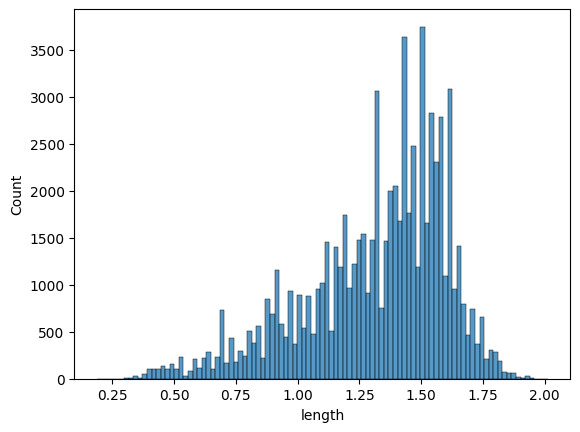

In [231]:
sns.histplot(df_train['length'])

<AxesSubplot:>

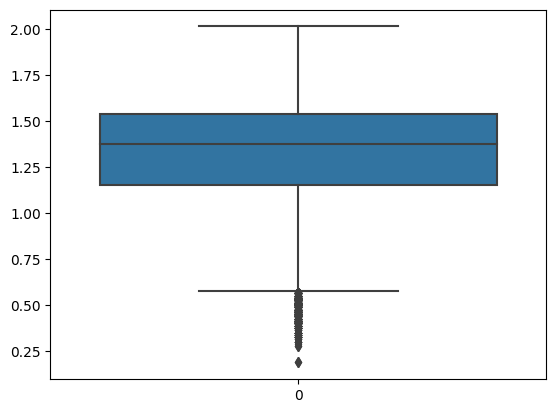

In [232]:
sns.boxplot(df_train['length'])

### Derived Weight Features 
- capture more nuanced information about weight distribution

In [233]:
df_train["weight_wo_viscera"] = df_train["shucked_weight"] - df_train['viscera_weight']
df_train["body_condition_index"] = np.sqrt(df_train['length']*df_train['weight']*df_train['shucked_weight'])

## One hot data

In [234]:
df_train = pd.get_dummies(df_train, columns = ["sex"])
y = df_train["age"]
X = df_train.drop(["id","age"], axis=1)

In [235]:
X

,length,diameter,height,weight,shucked_weight,viscera_weight,shell_weight,shell_ratio,shell_to_body_ratio,meat_yield,...,density,pseudo_BMI,length_poly,diameter_poly,log_weight,weight_wo_viscera,body_condition_index,sex_F,sex_I,sex_M
0,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,0.288160,0.223699,0.341056,...,43.117872,206.031566,2.325625,1.380625,3.400303,6.080968,23.715318,0,1,0
1,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,0.326531,0.246154,0.327179,...,41.746822,137.764512,1.210000,0.680625,2.435230,2.197086,7.198645,0,1,0
2,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,0.268879,0.211903,0.360685,...,42.804808,176.195292,1.925156,1.237656,3.249501,5.783298,19.744567,0,0,1
3,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,0.296027,0.228411,0.310017,...,42.195154,202.642226,2.890000,1.995156,3.944695,9.363103,41.869171,1,0,0
4,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,0.255630,0.203587,0.409598,...,54.522298,204.458617,1.562500,1.025156,3.190028,7.470093,18.673149,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74022,1.6625,1.2625,0.4375,50.660556,20.680960,10.361742,12.332033,0.243425,0.195770,0.328308,...,55.169476,264.675560,2.763906,1.593906,3.944695,10.319218,41.735071,1,0,0
74023,1.0750,0.8625,0.2750,10.446791,4.323299,2.296310,3.543687,0.339213,0.253293,0.309017,...,40.971573,138.139382,1.155625,0.743906,2.437709,2.026989,6.967922,0,1,0
74024,1.4875,1.2000,0.4125,29.483480,12.303683,7.540967,8.079607,0.274038,0.215094,0.327547,...,40.042075,173.272977,2.212656,1.440000,3.417185,4.762716,23.229263,1,0,0
74025,1.2125,0.9625,0.3125,16.768729,8.972617,2.919999,4.280774,0.255283,0.203367,0.426263,...,45.979860,171.711788,1.470156,0.926406,2.877440,6.052618,13.506739,0,1,0


In [189]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74027 entries, 0 to 74026
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          74027 non-null  int64  
 1   id                             74027 non-null  int64  
 2   length                         74027 non-null  float64
 3   diameter                       74027 non-null  float64
 4   height                         74027 non-null  float64
 5   weight                         74027 non-null  float64
 6   shucked_weight                 74027 non-null  float64
 7   viscera_weight                 74027 non-null  float64
 8   shell_weight                   74027 non-null  float64
 9   age                            74027 non-null  int64  
 10  shell_ratio                    74027 non-null  float64
 11  shell_to_body_ratio            74027 non-null  float64
 12  meat_yield                     74027 non-null 

## Check Nan value, inf, values

In [190]:
df_train.isin([np.inf, -np.inf]).sum()

index                            0
id                               0
length                           0
diameter                         0
height                           0
weight                           0
shucked_weight                   0
viscera_weight                   0
shell_weight                     0
age                              0
shell_ratio                      0
shell_to_body_ratio              0
meat_yield                       0
length_to_dinameter_ratio        0
weight_to_viscera_weight         0
weight_to_shellWeight_ratio      0
weight_to_shuckedWeight_ratio    0
surface_area                     0
volume                           0
density                          0
pseudo_BMI                       0
length_poly                      0
diameter_poly                    0
log_weight                       0
weight_wo_viscera                0
body_condition_index             0
sex_F                            0
sex_I                            0
sex_M               

In [191]:
df_train.isna().sum()

index                            0
id                               0
length                           0
diameter                         0
height                           0
weight                           0
shucked_weight                   0
viscera_weight                   0
shell_weight                     0
age                              0
shell_ratio                      0
shell_to_body_ratio              0
meat_yield                       0
length_to_dinameter_ratio        0
weight_to_viscera_weight         0
weight_to_shellWeight_ratio      0
weight_to_shuckedWeight_ratio    0
surface_area                     0
volume                           0
density                          0
pseudo_BMI                       0
length_poly                      0
diameter_poly                    0
log_weight                       0
weight_wo_viscera                0
body_condition_index             0
sex_F                            0
sex_I                            0
sex_M               

## In a nutshell processing

In [192]:
def processing(df):
    # change columns
    df.columns = ["id", "sex", "length", "diameter", "height", "weight", "shucked_weight", "viscera_weight", "shell_weight", "age"]
    
    df['shell_ratio'] = df['shell_weight'] / df['weight']
    df['shell_to_body_ratio'] = df['shell_weight'] / (df['weight'] + df['shell_weight'])
    df['meat_yield'] = df['shucked_weight'] / (df['weight'] + df['shell_weight'])
    df['length_to_dinameter_ratio'] = df['length'] / df['diameter']
    df['weight_to_viscera_weight'] = df['weight'] / df['viscera_weight']
    df['weight_to_shellWeight_ratio'] = df['weight'] / df['shell_weight']
    df['weight_to_shuckedWeight_ratio'] = df['weight'] / df['shucked_weight']
    
    #Geometric Features
    df["surface_area"] = 2*(df["length"] * df["diameter"] + df["length"] * df["height"] + df["diameter"] * df["height"])
    df["volume"] = df["length"]*df["diameter"]*df["height"]
    df["density"] = df["weight"] / df["volume"]
    df["pseudo_BMI"] = df["weight"] / (df["height"]**2)
    
    #polynomial features
    df['length_poly'] = df['length']**2
    df['diameter_poly'] = df['diameter']**2
    
    df['log_weight'] = np.log(df['weight'] + 1)
    
    df["weight_wo_viscera"] = df["shucked_weight"] - df['viscera_weight']
    df["body_condition_index"] = np.sqrt(df['length']*df['weight']*df['shucked_weight'])
    
    # one hot
    df = pd.get_dummies(df, columns = ["sex"])
    
    return df

## Split train & test

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

In [237]:
X_train

,length,diameter,height,weight,shucked_weight,viscera_weight,shell_weight,shell_ratio,shell_to_body_ratio,meat_yield,...,density,pseudo_BMI,length_poly,diameter_poly,log_weight,weight_wo_viscera,body_condition_index,sex_F,sex_I,sex_M
55975,1.6125,1.2500,0.4000,29.483480,13.735333,6.803880,8.646598,0.293269,0.226766,0.360223,...,36.568657,184.271750,2.600156,1.562500,3.417185,6.931453,25.553996,1,0,0
15915,0.4125,0.3000,0.1250,0.510291,0.255146,0.141747,0.141747,0.277778,0.217391,0.391304,...,32.988509,32.658624,0.170156,0.090000,0.412302,0.113398,0.231747,0,1,0
46895,0.8750,0.6750,0.2375,6.577084,2.778251,1.318252,1.984465,0.301724,0.231788,0.324503,...,46.887594,116.602043,0.765625,0.455625,2.025128,1.459999,3.998586,0,1,0
61589,1.2500,1.0125,0.3500,24.437269,11.325625,5.046211,6.803880,0.278422,0.217786,0.362523,...,55.167027,199.487910,1.562500,1.025156,3.236215,6.279414,18.599978,0,0,1
39712,1.6500,1.3000,0.4125,44.225220,18.342126,10.857859,13.182517,0.298077,0.229630,0.319506,...,49.982590,259.909466,2.722500,1.690000,3.811655,7.484268,36.584895,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12411,1.8000,1.4250,0.4375,52.673371,23.104843,10.900383,14.259799,0.270721,0.213045,0.345193,...,46.938120,275.191489,3.240000,2.030625,3.982917,12.204460,46.804037,0,0,1
6500,1.3375,1.0250,0.3125,21.885814,12.091062,4.479221,5.102910,0.233161,0.189076,0.448004,...,51.085192,224.110735,1.788906,1.050625,3.130517,7.611841,18.813104,0,0,1
21633,1.3250,1.0125,0.3625,22.920571,8.561549,5.244657,7.753588,0.338281,0.252773,0.279113,...,47.130984,174.425271,1.755625,1.025156,3.174739,3.316891,16.124892,0,0,1
59537,1.1375,0.9250,0.3500,18.299602,7.229122,4.507570,4.677668,0.255616,0.203578,0.314621,...,49.691312,149.384508,1.293906,0.855625,2.960084,2.721552,12.267027,0,0,1


## Test with base linear regression model

In [195]:
def Evaluating_model(y_test, y_pred):
    r2_test = float(format(r2_score(y_test,y_pred),'.3f'))
    RMSE = float(format(mean_squared_error(y_test,y_pred,squared=False),'0.3f'))
    MAE = float(format(mean_absolute_error(y_test, y_pred),'0.3f'))
    return (r2_test, RMSE, MAE)

In [196]:
base_lr = LinearRegression()
base_lr = base_lr.fit(X_train,y_train)
y_pred = base_lr.predict(X_test)
print("MAE: ", mean_absolute_error(y_test, y_pred))

MAE:  1.4664252157458397


In [198]:
Evaluating_model(y_test, y_pred)

(0.563, 2.083, 1.466)

In [199]:
def test_model_linear(X, y, name_model, model, Details):
    
    Scalers = [['None',False],['MinMaxScaler',MinMaxScaler()],['StandarScaler',StandardScaler()]]
    
    df_res = pd.DataFrame(index = None, columns =['Model','Details','Scaler','Feature_selection','R_score (train)','R_score (test)',
                                                  'RMSE','MAE','5-Fold Cross Validation'])
    for scaler in Scalers:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)
        
        if scaler[0] != 'None':
            sc = scaler[1].fit(X_train)
            X_train = sc.transform(X_train)
            X_test = sc.transform(X_test)
            
        sum_cols = X.columns.size
        
        for num_cols in range(10,sum_cols+1):
            print('\r', end='')
            print(scaler[0]+': '+str(num_cols)+'/'+str(sum_cols), end='')
            
            kBest = SelectKBest(f_regression,k = num_cols)
            kBest.fit(X_train, y_train)
            
            X_train_KBest = kBest.transform(X_train)
            X_test_KBest = kBest.transform(X_test)
           
            mod = model
            mod = model.fit(X_train_KBest, y_train)
            
            y_pred = mod.predict(X_test_KBest)
        
            r2_train = r2_score(y_train, mod.predict(X_train_KBest))
            r2_test, RMSE, MAE = Evaluating_model(y_test, y_pred)
            fcv = float(format(cross_val_score(mod, X_test, y_test).mean(),'.3f'))
            df_res = df_res.append(pd.Series({'Model':name_model,
                                              'Details':Details,
                                              'Scaler':scaler[0],
                                              'Feature_selection':num_cols,
                                              'R_score (train)':r2_train,
                                              'R_score (test)':r2_test,
                                              'RMSE':RMSE,'MAE':MAE,
                                              '5-Fold Cross Validation':fcv
                                             }),ignore_index = True)
    return df_res

In [200]:
df_lr =  test_model_linear(X, y, "LinearRegression",LinearRegression(), "")

StandarScaler: 27/27

In [201]:
df_lr.sort_values(by= ["MAE"]).reset_index()

,index,Model,Details,Scaler,Feature_selection,R_score (train),R_score (test),RMSE,MAE,5-Fold Cross Validation
0,71,LinearRegression,,StandarScaler,24,0.561689,0.564,2.082,1.466,0.544
1,70,LinearRegression,,StandarScaler,23,0.561313,0.563,2.083,1.466,0.544
2,45,LinearRegression,,MinMaxScaler,23,0.561313,0.563,2.083,1.466,0.547
3,46,LinearRegression,,MinMaxScaler,24,0.561687,0.564,2.082,1.466,0.547
4,24,LinearRegression,,None,27,0.561967,0.563,2.083,1.466,0.547
...,...,...,...,...,...,...,...,...,...,...
70,26,LinearRegression,,MinMaxScaler,4,0.480439,0.484,2.264,1.605,0.547
71,1,LinearRegression,,None,4,0.480439,0.484,2.264,1.605,0.547
72,50,LinearRegression,,StandarScaler,3,0.447597,0.451,2.336,1.652,0.544
73,25,LinearRegression,,MinMaxScaler,3,0.447597,0.451,2.336,1.652,0.547


# Build piple model

In [238]:
def test_model(X, y, name_model, model, Details):
    
    
    Scalers = [['None',False],['MinMaxScaler',MinMaxScaler()],['StandarScaler',StandardScaler()]]
    
    df_res = pd.DataFrame(index = None, columns =['Model','Details','Scaler','Feature_selection','R_score (train)','R_score (test)',
                                              'RMSE','MAE','5-Fold Cross Validation'])
    
    summ = 8 # print %%%%
    
    i = 0
    for scaler in Scalers:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)
        
        if scaler[0] != 'None':
            sc = scaler[1].fit(X_train)
            X_train = sc.transform(X_train)
            X_test = sc.transform(X_test)
            
            
        sum_cols = X.columns.size
        
#         lis_features = [8,9, 10]
        for num_cols in range(10,sum_cols+1):
            print('\r', end='')
            print(scaler[0]+': '+str(num_cols)+'/'+str(sum_cols), end='')
            i+=1
            
            
            kBest = SelectKBest(f_regression,k = num_cols)
            kBest.fit(X_train, y_train)
            
            X_train_KBest = kBest.transform(X_train)
            X_test_KBest = kBest.transform(X_test)
           
            mod = model
            mod = model.fit(X_train_KBest, y_train)
            
            y_pred = mod.predict(X_test_KBest)
        
            r2_train = r2_score(y_train, mod.predict(X_train_KBest))
            r2_test, RMSE, MAE = Evaluating_model(y_test, y_pred)
            fcv = float(format(cross_val_score(mod, X_test, y_test).mean(),'.3f'))
            df_res = df_res.append(pd.Series({'Model':name_model,
                                              'Details':Details,
                                              'Scaler':scaler[0],
                                              'Feature_selection':num_cols,
                                              'R_score (train)':r2_train,
                                              'R_score (test)':r2_test,
                                              'RMSE':RMSE,'MAE':MAE,
                                              '5-Fold Cross Validation':fcv
                                             }),ignore_index = True)
    return df_res

## KNeighbors

In [203]:
df_KNR_0 = test_model(X, y,'KNeighbors Regressor',KNeighborsRegressor(),'None')

None: 19/27

KeyboardInterrupt: 

In [ ]:
df_KNR_0.sort_values(by = ["MAE"])

## Decistion Tree Regressor

In [70]:
df_DTR_0 = test_model(X.copy(), y.copy(),'Decision Tree Regressor', DecisionTreeRegressor(max_depth  = 10, min_samples_split=5, random_state = SEED),'None')

100.000 % 

In [208]:
df_DTR_0.sort_values(by = ["MAE"]).head()

,Model,Details,Scaler,Feature_selection,R_score (train),R_score (test),RMSE,MAE,5-Fold Cross Validation
0,Decision Tree Regressor,None,None,8,0.621293,0.543,2.167,1.467,0.432
3,Decision Tree Regressor,None,MinMaxScaler,8,0.621293,0.542,2.168,1.467,0.433
2,Decision Tree Regressor,None,None,10,0.621774,0.541,2.170,1.468,0.432
5,Decision Tree Regressor,None,MinMaxScaler,10,0.621774,0.542,2.169,1.468,0.433
6,Decision Tree Regressor,None,StandarScaler,8,0.621293,0.542,2.169,1.468,0.432


## Random Forest Regression

In [204]:
df_RFR_0 = test_model(X.copy(), y.copy(),'Random Forest Regressor',
                    RandomForestRegressor(random_state = SEED),'None')

StandarScaler: 27/27

In [205]:
df_RFR_0.sort_values(by = ["MAE"]).head()

,Model,Details,Scaler,Feature_selection,R_score (train),R_score (test),RMSE,MAE,5-Fold Cross Validation
53,Random Forest Regressor,None,StandarScaler,27,0.939130,0.561,2.089,1.458,0.556
17,Random Forest Regressor,None,None,27,0.939152,0.561,2.089,1.458,0.556
35,Random Forest Regressor,None,MinMaxScaler,27,0.939150,0.561,2.088,1.458,0.556
29,Random Forest Regressor,None,MinMaxScaler,21,0.938959,0.561,2.088,1.459,0.556
50,Random Forest Regressor,None,StandarScaler,24,0.938990,0.560,2.091,1.459,0.556


## GradientBoostingRegressor

In [239]:
df_GBR_0 = test_model(X.copy(), y.copy(),'GradientBoostingRegressor',
                    GradientBoostingRegressor(random_state = SEED),'None')

StandarScaler: 26/26

In [240]:
df_GBR_0.sort_values(by = ["MAE"]).head()

,Model,Details,Scaler,Feature_selection,R_score (train),R_score (test),RMSE,MAE,5-Fold Cross Validation
50,GradientBoostingRegressor,None,StandarScaler,26,0.592970,0.587,2.027,1.404,0.581
33,GradientBoostingRegressor,None,MinMaxScaler,26,0.593028,0.587,2.027,1.404,0.581
16,GradientBoostingRegressor,None,None,26,0.592970,0.586,2.028,1.405,0.581
27,GradientBoostingRegressor,None,MinMaxScaler,20,0.590789,0.585,2.030,1.406,0.581
28,GradientBoostingRegressor,None,MinMaxScaler,21,0.590966,0.586,2.029,1.406,0.581


## Save model 

In [76]:
df_base = pd.concat([df_lr, df_GBR_0, df_RFR_0, df_KNR_0])

In [213]:
df_base.to_csv('base_model_features.csv', index=False)

In [215]:
df_base.sort_values(by=['MAE'])

,Model,Details,Scaler,Feature_selection,R_score (train),R_score (test),RMSE,MAE,5-Fold Cross Validation
1,GradientBoostingRegressor,None,None,9,0.585979,0.577,2.085,1.429,0.569
7,GradientBoostingRegressor,None,StandarScaler,9,0.585979,0.577,2.085,1.429,0.569
5,GradientBoostingRegressor,None,MinMaxScaler,10,0.585978,0.577,2.085,1.429,0.569
4,GradientBoostingRegressor,None,MinMaxScaler,9,0.585979,0.577,2.085,1.429,0.569
2,GradientBoostingRegressor,None,None,10,0.585978,0.577,2.085,1.429,0.569
8,GradientBoostingRegressor,None,StandarScaler,10,0.585978,0.577,2.085,1.429,0.569
6,GradientBoostingRegressor,None,StandarScaler,8,0.586081,0.577,2.084,1.430,0.569
3,GradientBoostingRegressor,None,MinMaxScaler,8,0.586081,0.577,2.084,1.430,0.569
0,GradientBoostingRegressor,None,None,8,0.586081,0.577,2.084,1.430,0.569
1,Random Forest Regressor,None,None,9,0.938392,0.558,2.130,1.474,0.548


## Gen submission

In [46]:
def gen_submission(model):
    
    df_sub = test_raw["id"].to_frame()
    
    ## processing
    df_test = pd.get_dummies(test_raw, columns = ["Sex"])
    df_test.drop(["id"], axis=1, inplace=True)
    
    ## gen file 
    pred = base_lr.predict(df_test)
    df_sub["Age"] = pred
    df_sub.to_csv("submission_crab.csv", index =False)

In [47]:
gen_submission(base_lr)